In [ ]:
!pip install keract

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import os 
os.chdir('/content/drive/My Drive/MVA/S2/DLMI')

# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#import keract
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score,precision_score
import keras
import tensorflow as tf
from utils.evaluation import *
from utils.utils import read_dataset,split_dataset,visualize_mitbih
%matplotlib inline

Using TensorFlow backend.


# 1. Data importation and visualization

In [3]:
data,labels = read_dataset('../mitbih_train.csv','MIT-BIH')

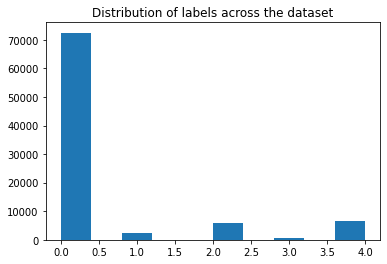

In [ ]:
plt.hist(labels)
plt.title('Distribution of labels across the dataset')
plt.show()

In [ ]:
unique_labels,props = np.unique(labels,return_counts=True)
df_props = pd.DataFrame([],columns=['proportion'],index = unique_labels)
df_props.index.name='label'
df_props['proportion'] = props/np.sum(props)
df_props

,proportion
label,
0,0.827729
1,0.025390
2,0.066108
3,0.007321
4,0.073452


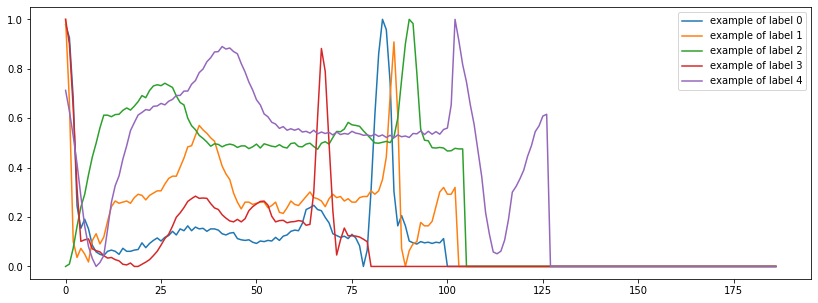

In [19]:
visualize_mitbih(data,labels)

# 2. Splitting dataset

We first split the dataset into three parts (training validation test), while keeping the proportions intact.

In [4]:
xtrain,ytrain,xval,yval,y_val_true, xtest,ytest,y_test_true = split_dataset(data,labels,validation=True)

# 3. Testing models

In [ ]:
%matplotlib inline

## 3.1 MLP

In [10]:
from models.mlp import Classifier_MLP

In [11]:
mlp = Classifier_MLP(output_directory='outputs/output_mlp/',input_shape=(data.shape[1],),
                     nb_classes = 5,verbose=True,
                     hidden_layers_size=(500,500,500))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 187)               0         
_________________________________________________________________
dropout (Dropout)            (None, 187)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 500)               94000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               250500    
_________________________________________________________________
dropout_2 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 500)               2

Epoch 1/100
821/821 [==============================] - 3s 4ms/step - loss: 1.4198 - accuracy: 0.6187 - val_loss: 1.1456 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 2/100
821/821 [==============================] - 3s 3ms/step - loss: 0.9854 - accuracy: 0.8277 - val_loss: 0.8793 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 3/100
821/821 [==============================] - 3s 3ms/step - loss: 0.8435 - accuracy: 0.8277 - val_loss: 0.8038 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 4/100
821/821 [==============================] - 3s 3ms/step - loss: 0.7895 - accuracy: 0.8277 - val_loss: 0.7533 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 5/100
821/821 [==============================] - 3s 3ms/step - loss: 0.7458 - accuracy: 0.8277 - val_loss: 0.7080 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 6/100
821/821 [==============================] - 3s 3ms/step - loss: 0.7084 - accuracy: 0.8277 - val_loss: 0.6670 - val_accuracy: 0.8277 - lr: 0.0010
Epoch 7/100
821/821 [==============================] - 3s 3ms/st

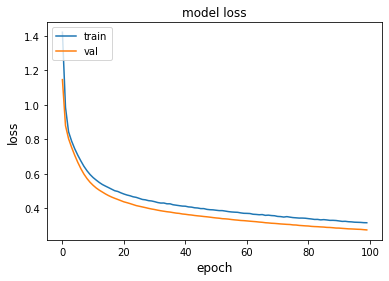

In [16]:
%matplotlib inline
hist = mlp.fit(xtrain,ytrain,xval,yval,y_val_true,batch_size=64,nb_epochs=100)

Let's evaluate our predictions on the validation set: 

In [18]:
ypred = mlp.predict(xval,np.argmax(yval,axis=1),return_df_metrics=False)
ypred = np.argmax(ypred,axis=1)
evaluate(y_val_true,ypred)

,accuracy,recall,precision,f1-score
0,0.921135,0.488251,0.560305,0.504909


Let's be more precise on each class. The following scores are computed considering each label against all the others.

In [20]:
get_binary_metrics(y_val_true,ypred)

,recall,precision,f1-score
0,0.989306,0.929776,0.958617
1,0.00675676,0.157895,0.012959
2,0.557858,0.829268,0.667011
3,0,0,0
4,0.887335,0.884586,0.885958


## 3.2 1D CNN

In [24]:
from models.1D_CNN import Classifier_1DCNN

SyntaxError: invalid syntax (<ipython-input-24-37d842f9728f>, line 1)

In [ ]:
#convolutional layers require a different shape
xtrain_r = xtrain.reshape(xtrain.shape[0],xtrain.shape[1],1)
xval_r = xval.reshape(xval.shape[0],xval.shape[1],1)

In [ ]:
cnn = Classifier_1DCNN('outputs/output_cnn', 
                       n_conv_block=2, n_filters=(64,64), kern_size=(5,5), 
                       n_stride=1, 
                       input_shape=(data.shape[1],1), 
                       add_FC=True, n_unit_FC=100,
                       verbose=True)

In [ ]:
hist = cnn.fit(xtrain,ytrain,xval,yval,y_val_true,batch_size=32,nb_epochs=10)

In [ ]:
ypred = cnn.predict(xval_r,np.argmax(yval,axis=1),return_df_metrics=False)
ypred = np.argmax(ypred,axis=1)
evaluate(y_val_true,ypred)

In [ ]:
get_binary_metrics(y_val_true,ypred)

## 3.3 ResNet

In [5]:
from models.resnet import Classifier_RESNET

In [6]:
#resnet requires a different shape since it is based on convolutional layers
xtrain_r = xtrain.reshape(xtrain.shape[0],xtrain.shape[1],1)
xval_r = xval.reshape(xval.shape[0],xval.shape[1],1)

In [13]:
resnet = Classifier_RESNET('outputs/output_resnet',input_shape=(data.shape[1],1),
                           nb_classes=5,n_feature_maps = (50,100,100),kernel_size=(8,5,3,2),
                           verbose=1,load_weights=False)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_33 (Conv1D)              (None, 187, 50)      450         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 187, 50)      200         conv1d_33[0][0]                  
__________________________________________________________________________________________________
activation_27 (Activation)      (None, 187, 50)      0           batch_normalization_36[0][0]     
____________________________________________________________________________________________

Train on 52532 samples, validate on 17511 samples
Epoch 1/2
52532/52532 [==============================] - 33s 623us/sample - loss: 0.1921 - accuracy: 0.9462 - val_loss: 0.2189 - val_accuracy: 0.9305
Epoch 2/2
52480/52532 [============================>.] - ETA: 0s - loss: 0.1256 - accuracy: 0.9639

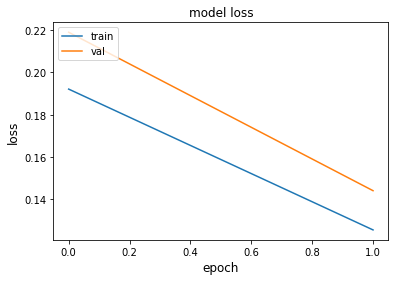

In [ ]:
%matplotlib inline
hist = resnet.fit(xtrain_r,ytrain,xval_r,yval,y_val_true,batch_size=32,nb_epochs=2)

In [ ]:
ypred = resnet.predict(xval_r,np.argmax(yval,axis=1),return_df_metrics=False)
ypred = np.argmax(ypred,axis=1)
evaluate(y_val_true,ypred)

,accuracy,recall,precision,f1-score
0,0.959397,0.775616,0.903069,0.810847


In [ ]:
get_binary_metrics(y_val_true,ypred)

,recall,precision,f1-score
0,0.97668,0.981964,0.979315
1,0.513514,0.904762,0.655172
2,0.953368,0.754614,0.842427
3,0.460938,0.921875,0.614583
4,0.973582,0.952128,0.962735


# 4. Interpreting models

In [ ]:
from interpretation.cam import *

In [ ]:
not_normal = []
for i in range(len(ypred)):
    if not ypred[i]==0: 
        not_normal.append(i)

## 4.1 1D-CNN model

In [ ]:
cnn_model = tf.keras.load_model('output_cnn/best_model.hdf5')

In [ ]:
display_conv_activations(resnet_model,xval_r[not_normal[0]])

## 4.2 ResNet model

In [ ]:
resnet_model = tf.keras.models.load_model('output_resnet/best_model.hdf5')

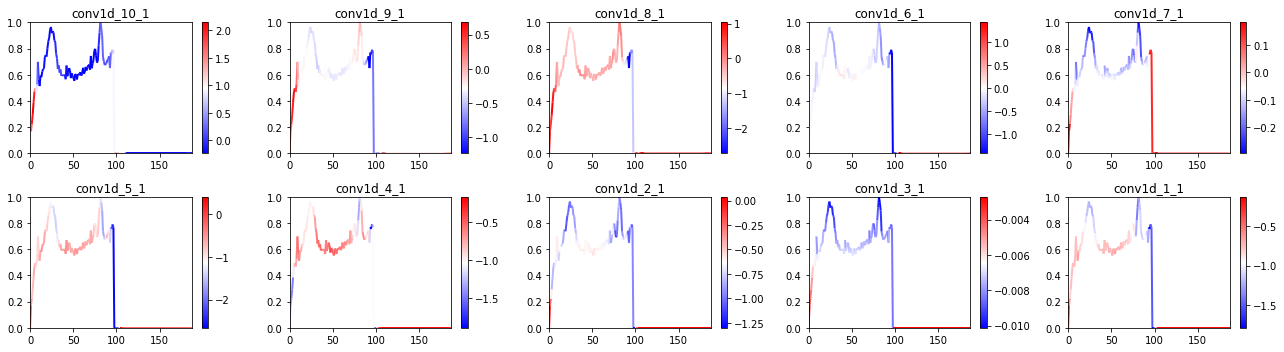

In [ ]:
display_conv_activations(resnet_model,xval_r[not_normal[0]])